In [1]:
import pandas as pd
import numpy as np 

In [38]:
df = pd.read_csv("../../resources/additional_data/CrPVD29N-vs-WTgrowthcurve.csv")
df['sample_id'] = df['genotype'] + df['rep'] +df['variant']
df['value'] = df['2^(-ΔCT)']
df['value_trans'] = np.log(df['value'])

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1200: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1200: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1200: FutureWarning: DataFrameGroupBy.apply op

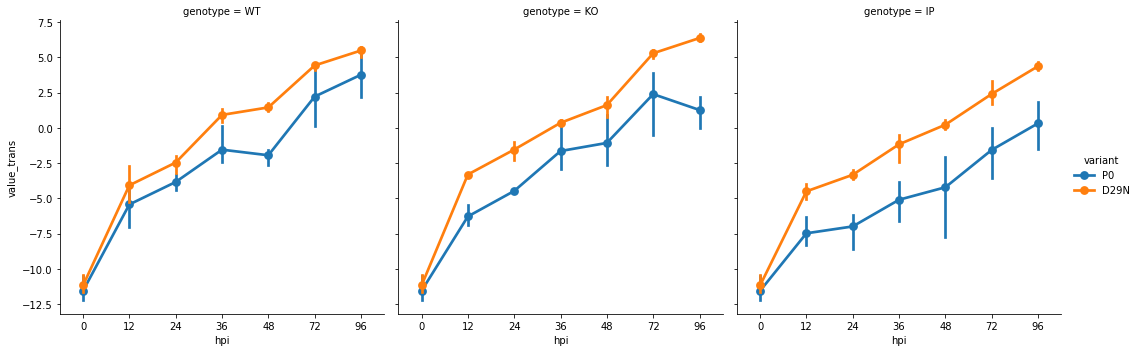

In [52]:
import seaborn as sns
g = sns.catplot(df,
kind='point',
x='hpi',
#row='rep',
y='value_trans',
hue='variant',
col='genotype')

In [19]:
df[df['genotype']=='WT']['value'].mean()

33.87370349972047

In [20]:
df[df['genotype']=='IP']['value'].mean()

7.132679381632381

In [32]:
0.1563*df[df['genotype']=='WT']['value'].mean()

5.294459857006309

In [10]:
%load_ext rpy2.ipython

Error importing in API mode: ImportError("dlopen(/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): symbol not found in flat namespace '_R_BaseEnv'")
Trying to import in ABI mode.


In [60]:
%%R -i df 

#library(lme4)
library(lmerTest)
library(rstatix)
library(ggpubr)
library(ggplot2)
library(ggdist) #for stat halfeye
library(DHARMa) #THE STAR OF THE SHOW INTERPRETATION OF MODEL FIT
library(MASS)


In [61]:
%%R

# Convert genotype to factor
df$genotype <- factor(df$genotype)
# Relevel the genotype factor with W as reference
df$genotype <- relevel(df$genotype, ref = "WT")

df$variant <- factor(df$variant)
df$variant <- relevel(df$variant, ref = "P0")


In [71]:
%%R 


df <- df[order(df$hpi), ]
lmm_model <- lmer(value_trans ~ hpi + variant * genotype+ (1 | sample_id) ,
                  data = df)

summary(lmm_model)



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: value_trans ~ hpi + variant * genotype + (1 | sample_id)
   Data: df

REML criterion at convergence: 548.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5731 -0.5412  0.3348  0.6556  1.8206 

Random effects:
 Groups    Name        Variance Std.Dev.
 sample_id (Intercept) 0.000    0.00    
 Residual              4.579    2.14    
Number of obs: 126, groups:  sample_id, 18

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             -8.373364   0.529841 119.000000 -15.804  < 2e-16 ***
hpi                      0.139843   0.006085 119.000000  22.982  < 2e-16 ***
variantD29N              1.842944   0.660388 119.000000   2.791 0.006128 ** 
genotypeIP              -2.605480   0.660388 119.000000  -3.945 0.000135 ***
genotypeKO              -0.433283   0.660388 119.000000  -0.656 0.513024    
variantD29N:genotypeIP   1.499716  

boundary (singular) fit: see ?isSingular


In [73]:
%%R
residuals <- resid(lmm_model)

# Check if residuals are in the same order as time variable in the data
all(names(residuals) == rownames(df))

[1] TRUE


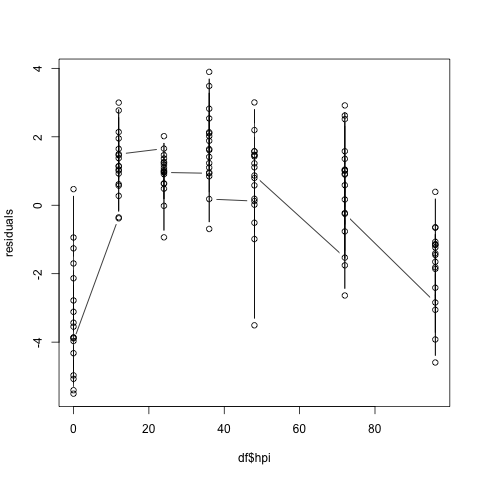

In [75]:
%%R 
plot(df$hpi, residuals, type = "b")

## residulas are in the right order 

In [63]:
%%R

check_autocorrelation(model)

## --> we need to account for autocorrelation

In [59]:
%%R 
library(nlme)


model <- lme(value_trans ~ hpi + variant+genotype, 
                random =~ hpi | sample_id,
                correlation = corAR1(form = ~ hpi | sample_id),
                data = df)

summary(model)



Linear mixed-effects model fit by REML
  Data: df 
       AIC      BIC    logLik
  574.4737 602.4316 -277.2368

Random effects:
 Formula: ~hpi | sample_id
 Structure: General positive-definite, Log-Cholesky parametrization
            StdDev       Corr  
(Intercept) 9.403325e-05 (Intr)
hpi         8.577517e-07 0     
Residual    2.145198e+00       

Correlation Structure: ARMA(1,0)
 Formula: ~hpi | sample_id 
 Parameter estimate(s):
Phi1 
   0 
Fixed effects:  value_trans ~ hpi + variant + genotype 
                Value Std.Error  DF    t-value p-value
(Intercept) -8.767778 0.4572491 107 -19.175059  0.0000
hpi          0.139843 0.0060999 107  22.925273  0.0000
variantD29N  2.631771 0.3822189  14   6.885507  0.0000
genotypeIP  -1.855622 0.4681206  14  -3.963983  0.0014
genotypeKO   0.000099 0.4681206  14   0.000212  0.9998
 Correlation: 
            (Intr) hpi    vrD29N gntyIP
hpi         -0.549                     
variantD29N -0.418  0.000              
genotypeIP  -0.512  0.000  0.0

Converting missing values (`NA`) into regular values currently not
  possible for variables of class `NULL`.


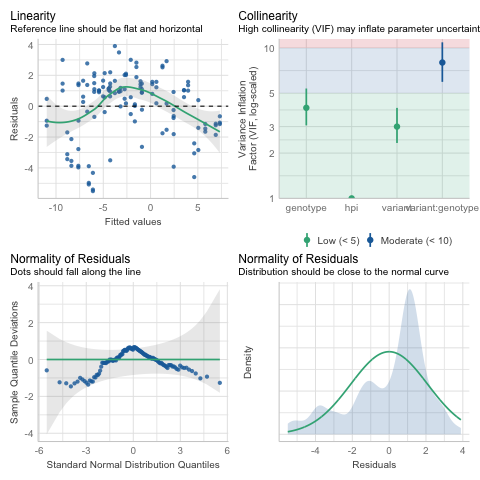

In [56]:
%%R 

# 1. Check residual diagnostics using performance package
library(performance)
check_model(model)

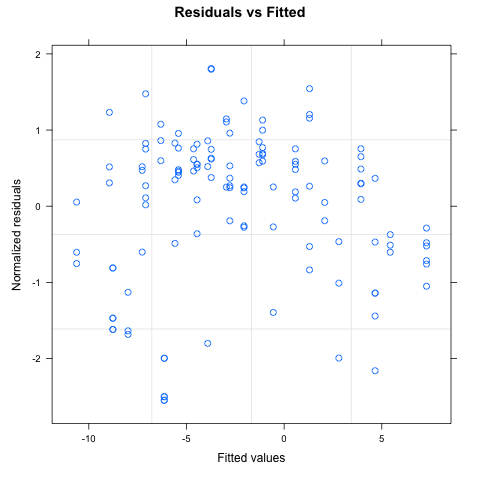

In [49]:
%%R 
plot(model, resid(., type="normalized") ~ fitted(.), main="Residuals vs Fitted")

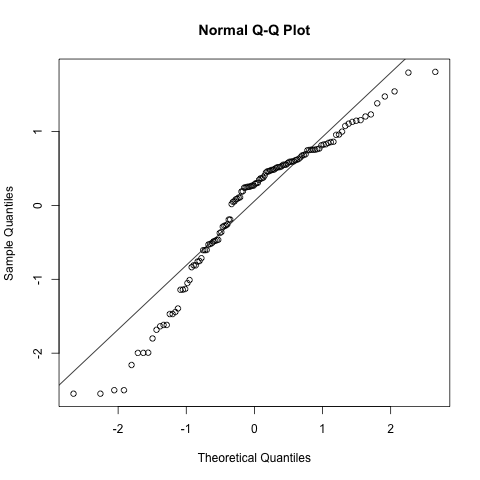

In [50]:
%%R 

qqnorm(resid(model, type = "normalized"))
qqline(resid(model, type = "normalized"))

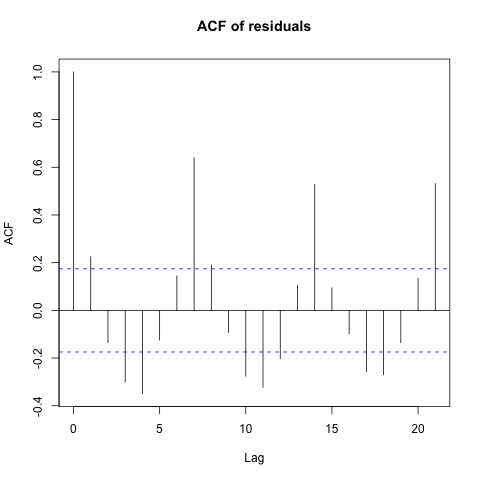

In [51]:
%%R

# 5. Check residual autocorrelation plot (should be flat if AR(1) accounted for)
acf(resid(model, type="normalized"), main="ACF of residuals")

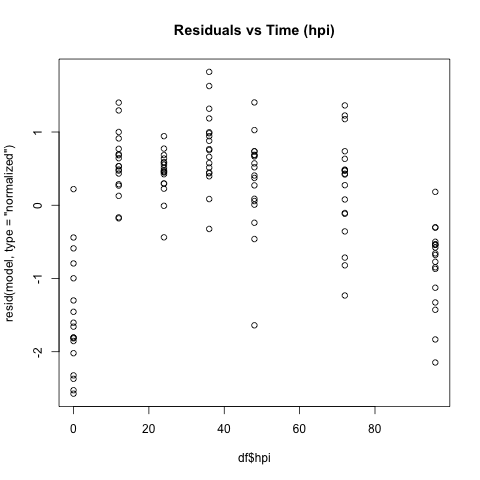

In [30]:
%%R

# 6. Check for heteroscedasticity against main predictors
plot(df$hpi, resid(model, type="normalized"), main="Residuals vs Time (hpi)")
